In [110]:
import os
import os.path as osp

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

import utils

# Prepare the ModelNet40 dataset

In [111]:
from scipy.stats import binned_statistic_2d

class ModelNet40(Dataset):
    def __init__(self,
        root: str, split: str,
        image_shape: tuple = (32, 32),
        proj_axes: list = [[0, 0, 1]]
    ):
        super().__init__()
        assert isinstance(image_shape, tuple) and len(image_shape) == 2, \
            "wrong image shape"

        assert osp.exists(root), \
            "invalid root for modelnet40 dataset"

        shape_names_file = osp.join(root, "modelnet40_shape_names.txt")
        assert osp.exists(shape_names_file), \
            "couldn't find shape-names txt file"
        with open(shape_names_file, 'r') as f:
            shape_names = sorted([line.strip() for line in f.readlines()])
            self.cls2idx = {v:i for i, v in enumerate(shape_names)}
            self.idx2cls = {i:v for i, v in enumerate(shape_names)}

        split_file = osp.join(root, f"modelnet40_{split}.txt")
        assert osp.exists(split_file), \
            "split file not exists"
        
        sample_names = []
        with open(split_file, 'r') as f:
            sample_names = sorted([line.strip() for line in f.readlines()])


        self.data = []
        for obj_name in sample_names:
            cls_name = obj_name.rsplit("_", 1)[0]
            self.data.append((osp.join(root, cls_name, f"{obj_name}.txt"), self.cls2idx[cls_name]))
        
        self.proj_axes = proj_axes
        self.image_shape = image_shape
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        file, gdth = self.data[index]
        points = np.loadtxt(file, delimiter=',')
        fmap = self.project_list(points, self.image_shape)
        return fmap, gdth
    
    def add_proj_dir(self, axis: np.ndarray):
        if not isinstance(axis, np.ndarray):
            axis = np.array(axis)
        assert len(axis.shape) == 1 and len(dir) == 3, "wrong projection axis shape"
        self.proj_axes.append(axis)

    def project_list(self, points: np.ndarray, image_shape: tuple):
        image_list = []
        for axis in self.proj_axes:
            image_list.append(self.project(points, axis, image_shape))
        return image_list


    def project(self, points: np.ndarray, axis: np.ndarray, image_shape: tuple):
        assert len(points.shape) == 2 and points.shape[1] >= 3, "wrong 3d coordinate shape"
        coords = np.copy(points[:, :3])
        # move to center and scaled to [-1, +1]
        coords = coords - coords.mean(axis=0)
        coords = coords / np.max(np.sqrt(np.sum(coords**2, axis=1)))

        R = utils.A2B_R(axis, [0, 0, 1])
        coords = (R @ coords.T).T

        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
        # from [-1, +1] to [0, H/W - 1]
        x = ((x + 1.0) / 2.0 * (image_shape[0] - 1)).astype(np.int32)
        y = ((y + 1.0) / 2.0 * (image_shape[1] - 1)).astype(np.int32)

        image = np.full((*image_shape, points.shape[-1] + 1), 0.0)
        z_buf = np.full(image_shape, -np.inf)

        for r, c, d, point in zip(x, y, z, points):
            if d > z_buf[r][c]:
                z_buf[r][c] = d
                image[r][c] = np.array([*point, d])
        
        return np.transpose(image) # move channel axis to the first

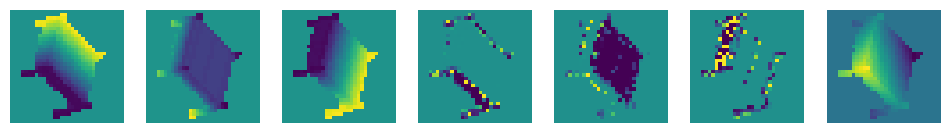

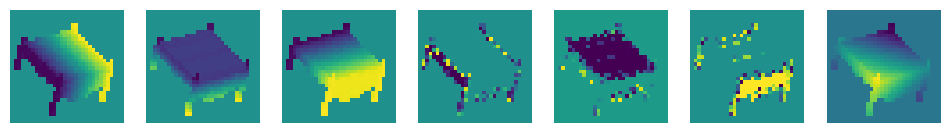

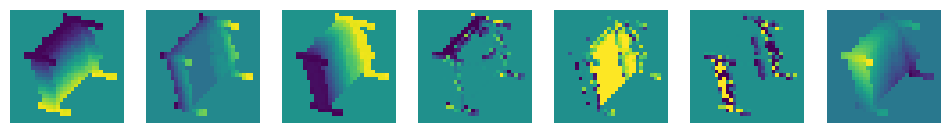

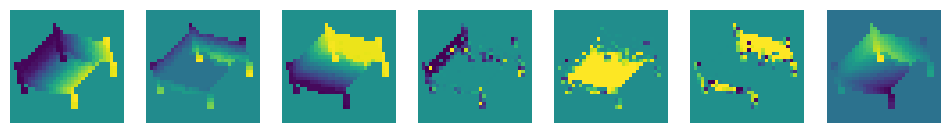

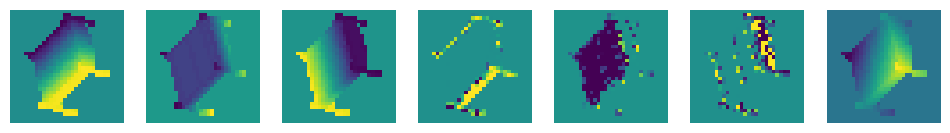

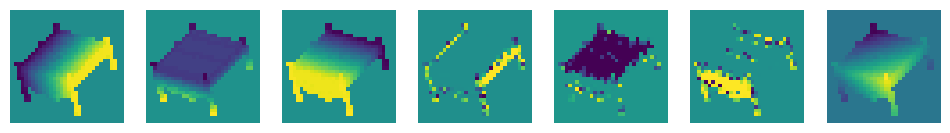

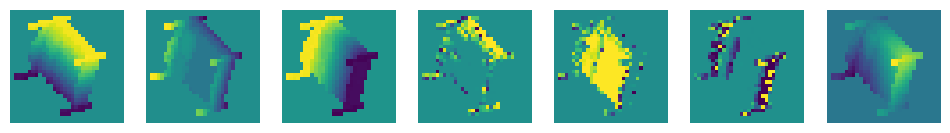

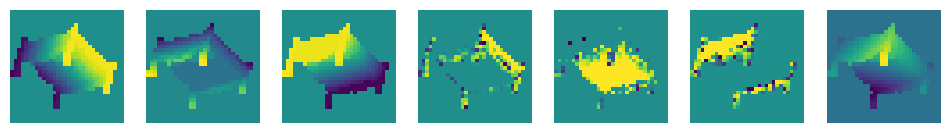

In [112]:
train_dataset = ModelNet40("./data/modelnet40", split="train", proj_axes = [
    [int((int(x) - 0.5) * 2) for x in list(bin(i)[2:].zfill(3))] for i in range(2**3)
])
# 定义训练集和验证集的大小
train_size = int(0.8 * len(train_dataset))  # 80% 用于训练
valid_size = len(train_dataset) - train_size  # 20% 用于验证

# 使用 random_split 进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

for iter, (fmap_list, gdth) in enumerate(train_dataset):
    for fmap in fmap_list:
        fig, axes = plt.subplots(1, 7, figsize=(12, 3))
        for ax, chnl in zip(axes, fmap):
            ax.axis("off")
            ax.imshow(chnl)
        plt.show()
    break

[[-1, -1, -1], [-1, -1, 1], [-1, 1, -1], [-1, 1, 1], [1, -1, -1], [1, -1, 1], [1, 1, -1], [1, 1, 1]]
